In [5]:
!pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.8/266.8 kB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00


In [6]:
# Импортируем необходимые библиотеки для анализа звуковых дорожек и построения моделей

import pandas as pd
import numpy as np
import librosa
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble, tree
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import tensorflow
import librosa.display
from tensorflow.keras import Input
import os
from PIL import Image
from pathlib import Path
import csv


from sklearn.metrics import accuracy_score

import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as subplots


import wandb
from wandb.sklearn import plot_precision_recall, plot_feature_importances, plot_summary_metrics
from wandb.sklearn import plot_class_proportions, plot_learning_curve, plot_roc

import warnings
warnings.filterwarnings("ignore")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Смотрим наше файловое хранилище  и выбираем из него папку с фрагментами песен
os.chdir("/content/drive/My Drive")
!ls

'1-5 вопросы.docx'
 2023_Разделение_на_минигруппы.xlsx
 5SowRbEtXrc.jpg
'A4 - Основной курс Про | Математика ОГЭ с Семёном.gsheet'
'A6 - Мастер-группа Про | Математика ОГЭ с Семёном. ЗАЧЕТЫ (Апрель).gsheet'
'A6 - Мастер-группа Про | Математика ОГЭ с Семёном. ЗАЧЕТЫ (Май) .gsheet'
'A6 - Мастер-группа Про | Математика ОГЭ с Семёном. ЗАЧЕТЫ (Март).gsheet'
'B3 - Мастер-группа Про | Математика ОГЭ с Семёном. ЗАЧЕТЫ (Апрель) .gsheet'
'B3 - Мастер-группа Про | Математика ОГЭ с Семёном. ЗАЧЕТЫ (Май).gsheet'
'B3 - Мастер-группа Про | Математика ОГЭ с Семёном. ЗАЧЕТЫ (Март) .gsheet'
 best_model_beit.pth
 best_model_MobileVit.pth
 best_model_PAN.pt
 best_model.pt
 best_model.pth
 best_model_unet.pt
 cats.jpg
'Colab Notebooks'
 DATA
 data.csv
 dataset
 data_song_classification.csv
 DWH_tinkoff.txt
 e70df564-4618-11ec-bfbd-02420a0005ef.sig
 e70df564-4618-11ec-bfbd-02420a0005ef.zip
 Elephant.jpg
'F6 - Основной курс Про | Математика ОГЭ с Даниром | 2.0.gsheet'
 final_Kravchenko8В01.zip
 ge

In [32]:
# function to link each of the wave files to their "target" emotion
# returning a pandas dataframe
def create_dataframe(dir):
    target = []
    audio = []
    for j in os.listdir(dir):
        for k in os.listdir(dir + "/" + j):
            target.append(str(j))
            audio.append(dir + "/"  + j + "/" + k)
    df = pd.DataFrame(columns=["audio", "target"])
    df["audio"] = audio
    df["target"] = target
    return df

In [33]:
musicMoodClass = "/content/drive/My Drive/dataset"

In [34]:
df_songs = create_dataframe(musicMoodClass)

In [35]:
df_songs.head()

,audio,target
0,/content/drive/My Drive/dataset/aggressive/676...,aggressive
1,/content/drive/My Drive/dataset/aggressive/676...,aggressive
2,/content/drive/My Drive/dataset/aggressive/676...,aggressive
3,/content/drive/My Drive/dataset/aggressive/676...,aggressive
4,/content/drive/My Drive/dataset/aggressive/676...,aggressive


In [36]:
df_songs["target"].value_counts()

target
aggressive    500
romantic      500
sad           500
dramatic      500
happy         500
Name: count, dtype: int64

In [10]:
import IPython

In [11]:
print(df_songs.iloc[0, 1])
IPython.display.Audio(df_songs.iloc[10, 0])

aggressive


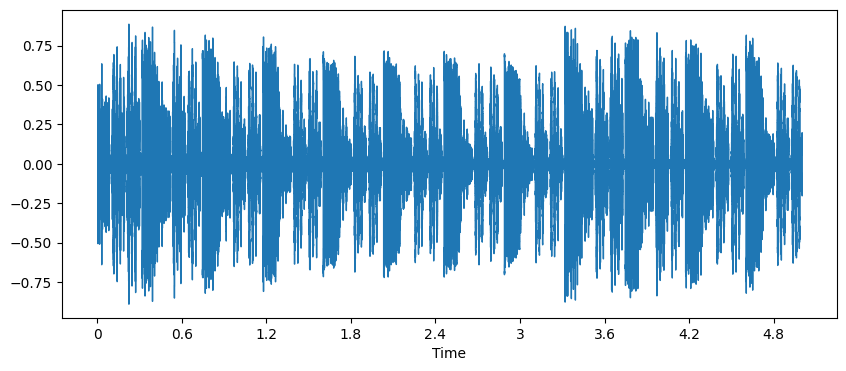

In [12]:
fig = plt.figure(figsize=(10, 4))
x, fs = librosa.load(df_songs.iloc[0, 0])
librosa.display.waveshow(x)
plt.show()

In [37]:
df_songs.values

array([['/content/drive/My Drive/dataset/aggressive/6768.wav',
        'aggressive'],
       ['/content/drive/My Drive/dataset/aggressive/6762.wav',
        'aggressive'],
       ['/content/drive/My Drive/dataset/aggressive/6766.wav',
        'aggressive'],
       ...,
       ['/content/drive/My Drive/dataset/happy/20022.wav', 'happy'],
       ['/content/drive/My Drive/dataset/happy/20024.wav', 'happy'],
       ['/content/drive/My Drive/dataset/happy/20025.wav', 'happy']],
      dtype=object)

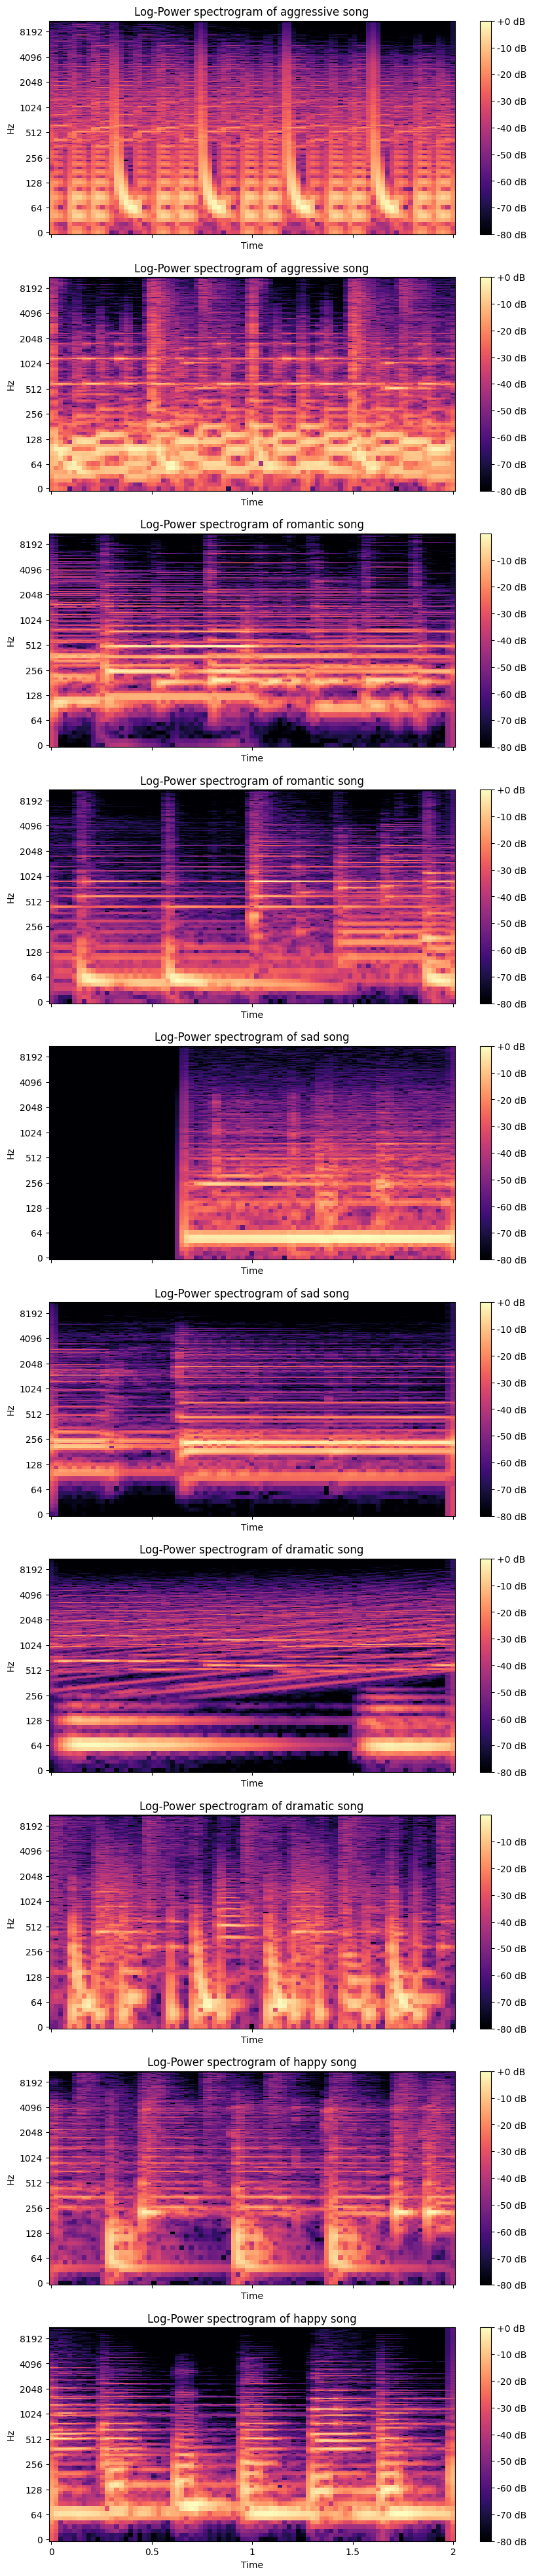

In [14]:
# Выбираем по 3 первые песни из каждого жанра, используем их спектограмму для кратковременное преобразование Фурье, чтобы визуально оценить особенности различных музыкальных жанров
dataset = []
# Создаем словарь классов, где ключи - название жанров музыки, а значения - цифры от 0 до 9

fig, ax = plt.subplots(nrows=len(df_songs.values)//250, sharex=True, sharey=True, figsize=(10,50))
counter = 0
for songname, type_of_song in df_songs.values[::250]:
    # С помощью библиотеки librosa загружаем наши песни в цикле, достаем фичи из спекторгаммы и по ним строим кратковременное преобразование Фурье (STFT)
    y, sr = librosa.load(songname, mono=True, duration=2, offset=0)
    ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512, n_mels=128)
    ps = librosa.power_to_db(ps**2)
    S = np.abs(librosa.stft(y))
    # Переводим STFT в dB из power, таким образом определяя, какие частоты наиболее выделялись в определенный промежуток времени
    imgdb = librosa.display.specshow(librosa.power_to_db(S**2, ref=np.max),
                                  sr=sr, y_axis='log', x_axis='time', ax=ax[counter])
    ax[counter].set(title=f'Log-Power spectrogram of {type_of_song} song')
    fig.colorbar(imgdb, ax=ax[counter], format="%+2.0f dB")
    counter+=1
    ps.shape

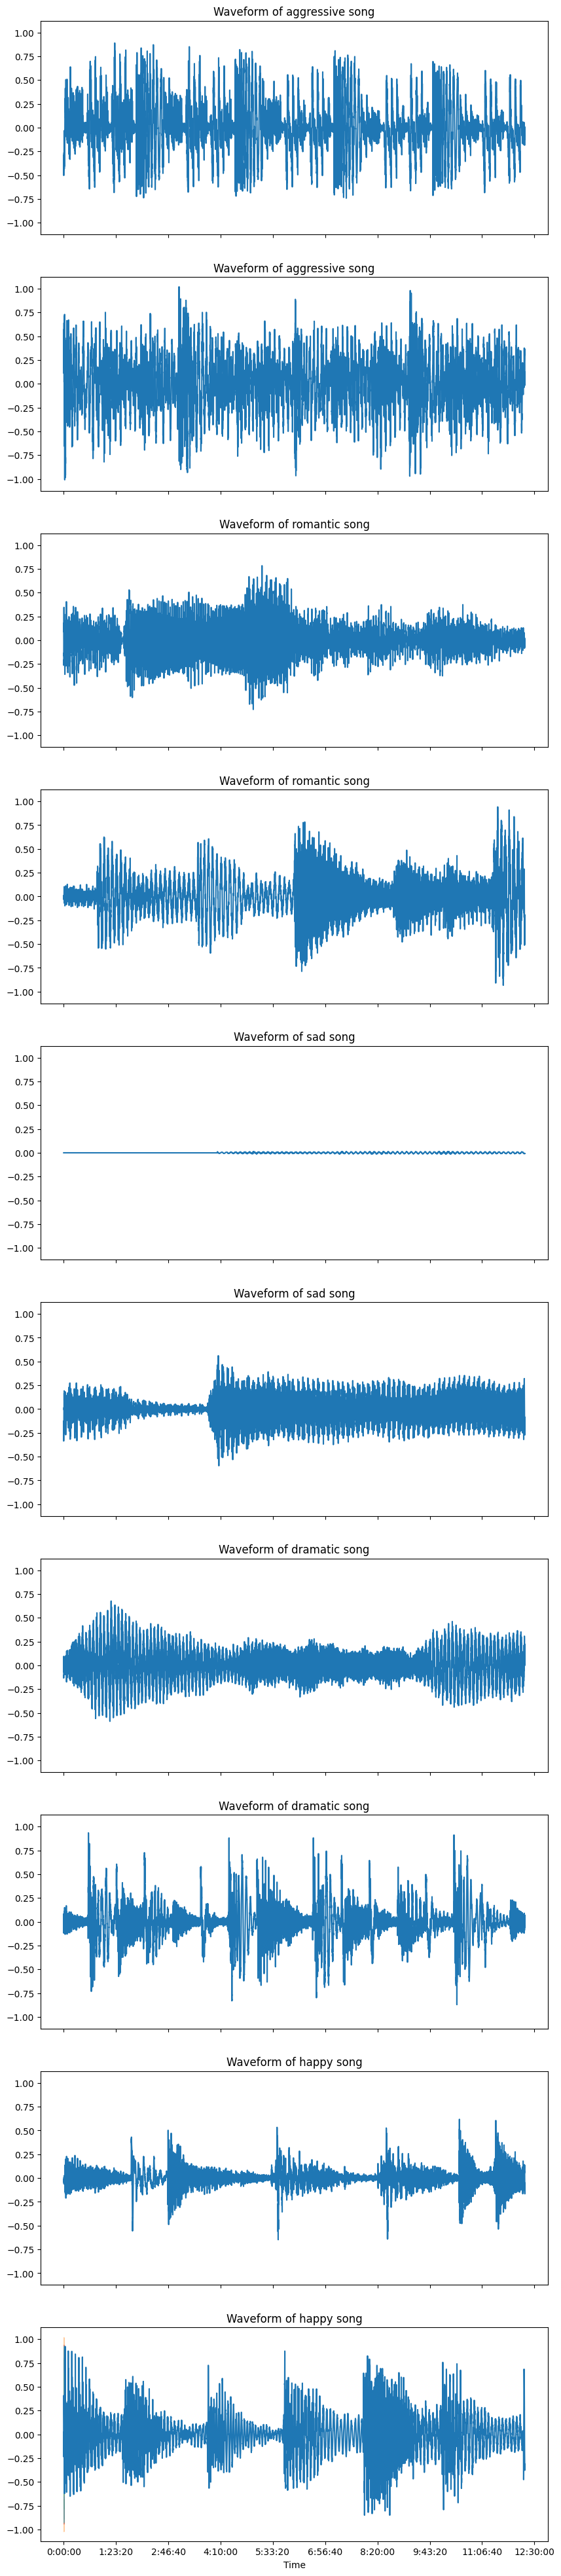

In [15]:
# Выбираем по 3 первые песни из каждого жанра, используем их спектограмму для кратковременное преобразование Фурье, чтобы визуально оценить особенности различных музыкальных жанров
dataset = []
# Создаем словарь классов, где ключи - название жанров музыки, а значения - цифры от 0 до 9

fig, ax = plt.subplots(nrows=len(df_songs.values)//250, sharex=True, sharey=True, figsize=(10,50))
counter = 0
for songname, type_of_song in df_songs.values[::250]:
    # С помощью библиотеки librosa загружаем наши песни в цикле, достаем фичи из спекторгаммы и по ним строим кратковременное преобразование Фурье (STFT)
    y, sr = librosa.load(songname, mono=True, duration=2, offset=0)
    # Переводим STFT в dB из power, таким образом определяя, какие частоты наиболее выделялись в определенный промежуток времени
    imgdb = librosa.display.waveshow(y, alpha=0.4)
    ax[counter].plot(y)
    ax[counter].set(title=f'Waveform of {type_of_song} song')
    counter+=1
    y.shape

In [17]:
# Вытаскиваем из песен основные фичи (мел-частотные кепстральные коэффициенты (MFCC), хромограммы и спектрограммы), создаем dataframe, где в качестве столбиков будут значения фичений

for songname, type_of_song in df_songs.values:

  y, sr = librosa.load(songname, mono=True, duration=2,sr=None)

  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)

  rms = librosa.feature.rms(y=y)

  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)

  spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)

  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)

  zcr = librosa.feature.zero_crossing_rate(y)

  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc = 20)

  tempo = float(librosa.beat.tempo(y=y, sr=sr)[0])

  to_append = f'{tempo} {np.mean(chroma_stft)} {np.mean(rms)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'
  for e in mfcc:
    to_append += f' {np.mean(e)}'
  to_append += f' {type_of_song}'
# Записываем полученные данные в data.csv
  file = open('data_song_classification.csv', 'a', newline='')
  with file:
      writer = csv.writer(file)
      writer.writerow(to_append.split())

In [10]:
# Смотрим на данные и избавляемся от нулевых значений
data = pd.read_csv('data_song_classification.csv')
data = data.set_axis(['tempo', 'chroma_stft', 'rms', 'spec_cent', 'spec_bw', 'rolloff', 'zcr', 'mfcc_0', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18', 'mfcc_19', 'type'],  axis='columns')

In [11]:
data

,tempo,chroma_stft,rms,spec_cent,spec_bw,rolloff,zcr,mfcc_0,mfcc_1,mfcc_2,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,type
0,120.185320,0.576735,0.161606,1298.466279,1759.092111,2651.944658,0.027019,-228.505692,183.460800,-19.620060,...,5.125187,4.532006,-5.120434,-8.827801,-3.386560,-3.621120,-5.659382,-3.291093,2.119722,aggressive
1,120.185320,0.682453,0.193011,2091.906626,3108.468391,4525.333330,0.024530,-167.574265,148.798264,-17.153797,...,5.555776,11.578320,5.931018,1.610489,5.928721,4.865321,-1.001732,-3.955744,0.241637,aggressive
2,120.185320,0.587723,0.192638,1656.494053,2387.292019,3519.620721,0.027253,-192.145035,173.698227,-17.051018,...,1.279439,14.795969,7.705712,-1.775918,5.987553,7.644205,1.010875,-5.936470,-4.544509,aggressive
3,120.185320,0.580105,0.148887,1450.698045,1860.945127,2973.573541,0.028402,-208.988083,188.386703,-31.263241,...,4.932614,3.959270,-4.299226,-7.042138,-6.305833,-5.932078,-4.652926,-5.079377,-0.635844,aggressive
4,99.384014,0.545830,0.186605,2009.818261,2845.553663,4271.415790,0.026836,-198.278717,149.130402,-11.301038,...,4.693185,2.462649,1.906607,-0.658720,1.014884,-0.485337,-2.507965,-9.971106,-8.158277,aggressive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2429,161.499023,0.362053,0.212099,2498.984804,3425.787759,5658.875993,0.041442,-147.139252,146.300583,-6.571464,...,-4.108517,-5.784340,-3.949282,-2.941063,-1.973917,-6.778847,-1.644812,-13.005033,-2.695103,happy
2430,120.185320,0.416348,0.191368,2590.455492,3553.035813,5840.601292,0.044930,-159.265610,142.145721,2.446535,...,-4.356225,-3.834460,-4.381970,-5.732567,-5.962437,-8.854736,0.547984,-6.318519,5.891159,happy
2431,120.185320,0.419912,0.208533,2514.910045,3582.308440,5738.536398,0.036260,-157.069458,142.381668,3.125985,...,-1.052909,-0.580084,-1.664961,-4.021811,-1.420596,-4.152445,1.561624,-7.194024,5.197496,happy
2432,120.185320,0.494573,0.184290,2662.255139,3654.153019,6077.093118,0.043770,-165.549942,139.417633,5.176997,...,0.411051,-5.414495,-1.168092,0.803111,4.265185,-3.296812,0.571739,-8.442852,3.154878,happy


In [13]:
# Считываем все типы жанров, делаем разметку данных на тестовые и тренировочные
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
print(np.unique(y))
scaler = StandardScaler()
X=np.array(data.iloc[:, :-1])
test_size=0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=42)
X_train = scaler.fit_transform(np.array(X_train, dtype = float))
X_test = scaler.transform(np.array(X_test, dtype = float))

[0 1 2 3 4]


In [28]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [31]:
svcClf = SVC()
svcClf.fit(X_train, y_train)
svc_params = svcClf.get_params()
run = wandb.init(project="Song_mood_classification", name ="SVC", config=svc_params)

run.config.update(
    {
        "test_size": test_size,
        "train_len": len(X_train),
        "test_len": len(X_test),
    }
)

# log additional visualisations to wandb
plot_class_proportions(y_train, y_test, data['type'].unique())
plot_learning_curve(svcClf, X_train, y_train)
plot_summary_metrics(svcClf, X_train, y_train, X_test, y_test)


run.finish()

In [32]:
forestClf = ensemble.RandomForestClassifier()
forestClf.fit(X_train, y_train)
foresctClf_y_probas = forestClf.predict_proba(X_test)
foresctClf_importances = forestClf.feature_importances_
foresctClf_indices = np.argsort(foresctClf_importances)[::-1]

forestClf_params = forestClf.get_params()
run = wandb.init(project="Song_mood_classification", name="RandomForestClassifier", config=forestClf_params)

run.config.update(
    {
        "test_size": test_size,
        "train_len": len(X_train),
        "test_len": len(X_test),
    }
)

# log additional visualisations to wandb
plot_class_proportions(y_train, y_test, data['type'].unique())
plot_learning_curve(forestClf, X_train, y_train)
plot_summary_metrics(forestClf, X_train, y_train, X_test, y_test)
plot_feature_importances(forestClf)

run.finish()

In [33]:
nbClf = GaussianNB()
nbClf.fit(X_train, y_train)
nbClf_params = nbClf.get_params()
run = wandb.init(project="Song_mood_classification", name ="GaussianNB", config=nbClf_params)

run.config.update(
    {
        "test_size": test_size,
        "train_len": len(X_train),
        "test_len": len(X_test),
    }
)

# log additional visualisations to wandb
plot_class_proportions(y_train, y_test, data['type'].unique())
plot_learning_curve(nbClf, X_train, y_train)
plot_summary_metrics(nbClf, X_train, y_train, X_test, y_test)


run.finish()

In [34]:
knnClf = KNeighborsClassifier()
knnClf.fit(X_train, y_train)
knnClf_params = knnClf.get_params()
run = wandb.init(project="Song_mood_classification", name ="KNeighborsClassifier", config=knnClf_params)

run.config.update(
    {
        "test_size": test_size,
        "train_len": len(X_train),
        "test_len": len(X_test),
    }
)

# log additional visualisations to wandb
plot_class_proportions(y_train, y_test, data['type'].unique())
plot_learning_curve(knnClf, X_train, y_train)
plot_summary_metrics(knnClf, X_train, y_train, X_test, y_test)


run.finish()

In [35]:
treeClf = tree.DecisionTreeClassifier()
treeClf.fit(X_train, y_train)
treeClf_y_probas = treeClf.predict_proba(X_test)
treeClf_importances = treeClf.feature_importances_
treeClf_indices = np.argsort(treeClf_importances)[::-1]
treeClf_params = treeClf.get_params()

run = wandb.init(project="Song_mood_classification", name="RandomForestClassifier", config=treeClf_params)

run.config.update(
    {
        "test_size": test_size,
        "train_len": len(X_train),
        "test_len": len(X_test),
    }
)

# log additional visualisations to wandb
plot_class_proportions(y_train, y_test, data['type'].unique())
plot_learning_curve(treeClf, X_train, y_train)
plot_summary_metrics(treeClf, X_train, y_train, X_test, y_test)
plot_feature_importances(treeClf)

run.finish()

In [36]:
models = [svcClf, forestClf, nbClf, knnClf, treeClf]

# Initialize lists to store model names and accuracy scores
model_names = []
accuracy_scores = []

# Print accuracy scores and store model names and accuracy scores
print("Accuracy score is:")
for model in models:
    pred = model.predict((X_test))
    model_accuracy = accuracy_score(y_test, pred)
    accuracy_scores.append(model_accuracy)
    model_names.append(type(model).__name__)
    print(f'| {type(model).__name__:22} | {model_accuracy:.3f} |')

# Round accuracy scores to 3 decimal places
accuracy_scores_rounded = [round(score, 3) for score in accuracy_scores]

# Create a bar plot using Plotly
fig = go.Figure(data=[go.Bar(x=model_names, y=accuracy_scores, text=accuracy_scores_rounded, textposition="auto")])

# Update layout for better visualization
fig.update_layout(title="Accuracy Score of Models",
                  xaxis_title="Model",
                  yaxis_title="Accuracy",
                  width=1000,
                  height=500)


# Show the plot
fig.show("notebook")

Output hidden; open in https://colab.research.google.com to view.

In [15]:
forest_classifier = ensemble.RandomForestClassifier(random_state=42)

In [10]:
param_grid = {
    'n_estimators': [200, 300, 500],
    # 'max_features': ['auto', 'sqrt', 'log2'],
    'max_features': [None, 'sqrt', 'log2', 1, 0.5],  # Updated max_features values
    'max_depth' : [4, 5, 6 ,7 ,8, 9, 10],
    'criterion' :['gini', 'entropy']
}

In [11]:
clf = GridSearchCV(estimator=forest_classifier,
                   param_grid=param_grid,
                   cv=3)

In [14]:
clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'max_features': [None, 'sqrt', 'log2', 1, 0.5],
                         'n_estimators': [200, 300, 500]})

In [15]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 500}

In [16]:
random_forest_model = ensemble.RandomForestClassifier(criterion = 'entropy',
                                                    max_depth = 10,
                                                    max_features = 'sqrt',
                                                    n_estimators = 500,
                                                    random_state=42)

In [17]:
random_forest_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=500,
                       random_state=42)

In [18]:
predictions = random_forest_model.predict(X_test)

In [19]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

report = classification_report(y_test, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95        91
           1       0.86      0.82      0.84        98
           2       0.85      0.93      0.89        88
           3       0.83      0.79      0.81       109
           4       0.86      0.83      0.84       101

    accuracy                           0.86       487
   macro avg       0.86      0.87      0.87       487
weighted avg       0.86      0.86      0.86       487



In [20]:
model_accuracy = accuracy_score(y_test, predictions)
model_accuracy

0.864476386036961

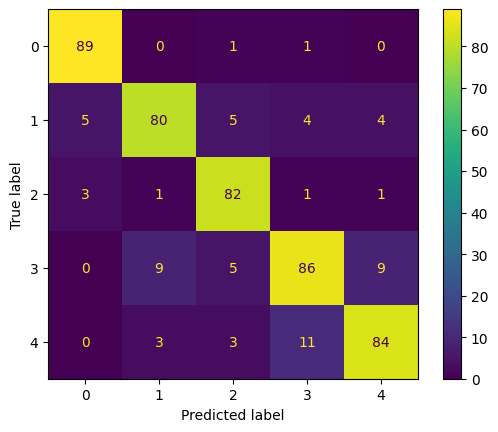

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions)

In [50]:
import pickle

# save
with open('random_forest_model_song_mood.pkl','wb') as f:
    pickle.dump(random_forest_model,f)

In [21]:
feature_names = data.columns.values[:-1]
importances = random_forest_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest_model.estimators_], axis=0)

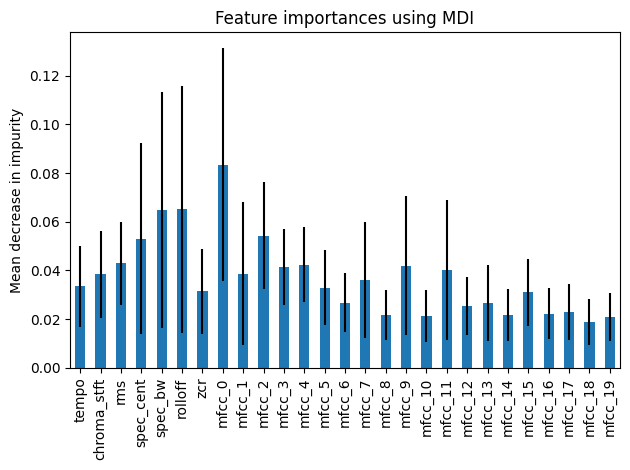

In [22]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [23]:
from sklearn.inspection import permutation_importance

In [24]:
result = permutation_importance(
   random_forest_model, X_train, y_train, n_repeats=10, random_state=42
)

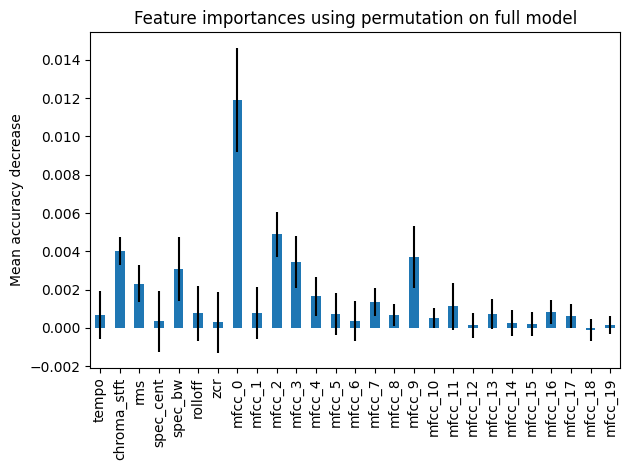

In [25]:
forest_importances = pd.Series(result.importances_mean, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [41]:
# Формируем датасет
dataset = []
for songname, type_of_song in df_songs.values:
    y, sr = librosa.load(songname, mono=True, duration=2, offset=0)
    ps = librosa.feature.melspectrogram(y=y, sr=sr, hop_length = 256, n_fft = 512, n_mels=128)
    ps = librosa.power_to_db(ps**2)
    S = np.abs(librosa.stft(y))
    dataset.append((ps, type_of_song))

In [ ]:
df_songs.values

In [44]:
len(dataset)

2500

In [48]:
# Импортируем библиотеки для глубинного обучения
import tensorflow
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
import keras

from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [60]:
mood = {'aggressive': 0, 'romantic': 1, 'sad': 2, 'dramatic': 3, 'happy': 4}

In [62]:
import random
# Перемешиваем данные, чтобы создать более объективную среду обучения, таким образом повысив точность модели
random.shuffle(dataset)

train_data = dataset[:1800]
valid_data = dataset[1800:2200]
test_data = dataset[2200:]

X_train, Y_train = zip(*train_data)
X_valid, Y_valid = zip(*valid_data)
X_test, Y_test = zip(*test_data)

# Решейпаем наши данные для CNN обучения
X_train = np.array([x.reshape( (128, 173, 1) ) for x in X_train])
X_valid = np.array([x.reshape( (128, 173, 1) ) for x in X_valid])
X_test = np.array([x.reshape( (128, 173, 1) ) for x in X_test])

# Энкодим наших учителей в категориальные признаки с помощью one-hot
Y_train = np.array(tensorflow.keras.utils.to_categorical(tuple(map(lambda n: mood[n], list(Y_train)))))
Y_valid = np.array(tensorflow.keras.utils.to_categorical(tuple(map(lambda n: mood[n], list(Y_valid)))))
Y_test = np.array(tensorflow.keras.utils.to_categorical(tuple(map(lambda n: mood[n], list(Y_test)))))

In [63]:
inputs = keras.Input(shape=(128, 173, 1))
x = layers.Conv2D(32, 3, activation="relu")(inputs) # слой светки
x = layers.Conv2D(64, 3, activation="relu")(x) # слой светки
block_1_output = layers.MaxPooling2D(3)(x) # уменьшаем размерность(качество) нашей картинки, чтобы упростить обработку

x = layers.Conv2D(64, 3, activation="relu", padding = "same")(block_1_output) # подключаем два предыдущих слоя к текущему слою свертки, чтобы увечилить точность и избежать случая, когда функция обратного распространения ошибки не дойдет до конца
x = layers.Conv2D(64, 3, activation="relu", padding = "same")(x)

# Последующие слои проектируем аналогично предыдущим

block_2_output = layers.add([x, block_1_output])

x = layers.Conv2D(64, 3, activation="relu", padding = "same")(block_2_output)
x = layers.Conv2D(64, 3, activation="relu", padding = "same")(x)

block_3_output = layers.add([x, block_2_output])

x = layers.Conv2D(64, 3, activation="relu",  padding = "same")(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation = "relu")(x)
# Дропаем, то есть отключаем половину рандомных нейронов из полсносвязной сети, чтобы избежать переобучения
x = layers.Dropout(0.5)(x)
# Последний словй служит для классификация по 10 видам
outputs = layers.Dense(5, activation = 'softmax')(x)

In [64]:
from keras import metrics
from keras.callbacks import EarlyStopping

NUM_EPOCHS = 100
BATCH_SIZE = 32

In [65]:
wandb.init(project='cv-songs-mood-classification')

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [66]:
# обучаем модель за 100 эпох

model = keras.Model(inputs, outputs, name = "Resnet")

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
total = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = NUM_EPOCHS, validation_split = 0.2, callbacks=[es, WandbMetricsLogger(),
       ])

Epoch 1/100
 6/45 [===>..........................] - ETA: 2s - loss: 3.2424 - accuracy: 0.1979

45/45 [==============================] - 16s 70ms/step - loss: 1.8382 - accuracy: 0.2167 - val_loss: 1.6107 - val_accuracy: 0.1583
Epoch 2/100
45/45 [==============================] - 3s 59ms/step - loss: 1.6053 - accuracy: 0.2403 - val_loss: 1.5654 - val_accuracy: 0.3972
Epoch 3/100
45/45 [==============================] - 3s 59ms/step - loss: 1.4603 - accuracy: 0.3403 - val_loss: 1.3574 - val_accuracy: 0.4556
Epoch 4/100
45/45 [==============================] - 3s 60ms/step - loss: 1.3381 - accuracy: 0.4111 - val_loss: 1.2420 - val_accuracy: 0.4889
Epoch 5/100
45/45 [==============================] - 3s 65ms/step - loss: 1.2527 - accuracy: 0.4583 - val_loss: 1.1682 - val_accuracy: 0.5000
Epoch 6/100
45/45 [==============================] - 3s 60ms/step - loss: 1.1995 - accuracy: 0.4764 - val_loss: 1.1465 - val_accuracy: 0.5139
Epoch 7/100
45/45 [==============================] - 3s 61ms/step - loss: 1.1702 - accuracy: 0.4910 - val_loss: 1.0310 - val_accuracy: 0.5889
Epoch 8/100
45/45

In [68]:
model.save_weights('songs_mood_classification.weights.h5')

In [69]:
test = keras.Model(inputs, outputs, name = "Resnet")

In [70]:
test.summary()

Model: "Resnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 173, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 126, 171, 32)         320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 124, 169, 64)         18496     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 41, 56, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                          

In [72]:
test.load_weights('songs_mood_classification.weights.h5')

10/10 [==============================] - 1s 60ms/step


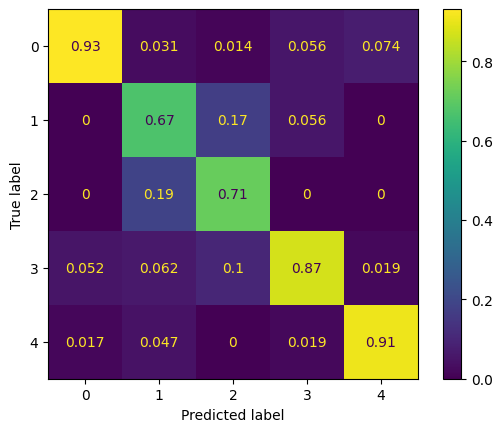

In [73]:
#Предсказываем
y_prediction = test.predict(X_test)
y_prediction = np.argmax(y_prediction, axis = 1)
y_test=np.argmax(Y_test, axis=1)
#Созадем матрицу ошибок и выводим ее значения
ConfusionMatrixDisplay.from_predictions(y_test, y_prediction , normalize='pred')

In [74]:
model_accuracy = accuracy_score(y_test, y_prediction)
model_accuracy

0.81

In [75]:
report = classification_report(y_test, y_prediction)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.84      0.89        64
           1       0.67      0.74      0.70        58
           2       0.71      0.81      0.76        62
           3       0.87      0.76      0.81        62
           4       0.91      0.91      0.91        54

    accuracy                           0.81       300
   macro avg       0.82      0.81      0.81       300
weighted avg       0.82      0.81      0.81       300



In [76]:
import numpy as np
from tqdm import tqdm
import os
# import cv2
import shutil
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow. keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from IPython.display import Image
from sklearn.metrics import confusion_matrix
import itertools
import datetime
import time

In [77]:
mobile = tf.keras.applications.mobilenet.MobileNet()
base_model = MobileNet(weights = 'imagenet', include_top = False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
preds = Dense(5, activation = 'softmax')(x)

17225924/17225924 [==============================] - 0s 0us/step


17225924/17225924 [==============================] - 0s 0us/step


In [78]:
for layer in base_model.layers[:20]: layer.trainable=False
model=Model(inputs=base_model.input, outputs=preds)
inputs = Input(shape=(128, 173, 1))
new_model = Sequential()
new_model.add(inputs)
new_model.add(layers.Conv2D(32, 3, activation="relu"))
for layer in model.layers[2:]:
    new_model.add(layer)
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 126, 171, 32)      320       
                                                                 
 conv1_bn (BatchNormalizati  multiple                  128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           multiple                  0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  multiple                  288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  multiple                  128       
 zation)                                                         
                                                        

In [79]:
new_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics=['acc'])

In [80]:
n_epochs = 25
run = wandb.init(project="CNN", name ="song_mood_classification_with_cnn_MobileNet")
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                 patience=5,
                                                 restore_best_weights=True)

history = new_model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = n_epochs, validation_split = 0.2, callbacks=[early_stopper,  WandbMetricsLogger()] )



run.finish()

epoch/accuracy,▁▁▂▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██████
epoch/epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███████
epoch/val_loss,██▇▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch/accuracy,0.87361
epoch/epoch,24
epoch/learning_rate,0.001
epoch/loss,0.36045
epoch/val_accuracy,0.8


Epoch 1/25
 6/45 [===>..........................] - ETA: 6s - loss: 1.5395 - acc: 0.3073

45/45 [==============================] - 26s 250ms/step - loss: 1.0581 - acc: 0.5826 - val_loss: 2.3932 - val_acc: 0.2167
Epoch 2/25
45/45 [==============================] - 8s 183ms/step - loss: 0.4317 - acc: 0.8646 - val_loss: 2.4514 - val_acc: 0.2556
Epoch 3/25
45/45 [==============================] - 8s 188ms/step - loss: 0.1942 - acc: 0.9528 - val_loss: 1.7119 - val_acc: 0.3750
Epoch 4/25
45/45 [==============================] - 8s 186ms/step - loss: 0.0946 - acc: 0.9778 - val_loss: 1.0958 - val_acc: 0.5889
Epoch 5/25
45/45 [==============================] - 8s 186ms/step - loss: 0.0898 - acc: 0.9778 - val_loss: 0.4195 - val_acc: 0.8417
Epoch 6/25
45/45 [==============================] - 8s 185ms/step - loss: 0.0646 - acc: 0.9778 - val_loss: 0.3448 - val_acc: 0.8806
Epoch 7/25
45/45 [==============================] - 8s 182ms/step - loss: 0.0544 - acc: 0.9778 - val_loss: 0.2643 - val_acc: 0.9000
Epoch 8/25
45/45 [==============================] - 8s 184ms/step - loss: 0.0493 - acc

epoch/acc,▁▆▇███████████
epoch/epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_acc,▁▁▃▅▇▇████████
epoch/val_loss,██▆▄▂▁▁▁▁▁▁▁▁▁
epoch/acc,0.97986
epoch/epoch,13
epoch/learning_rate,0.0001
epoch/loss,0.03035
epoch/val_acc,0.90833


In [81]:
new_model.save_weights('songs_mood_classification_MobileNet.weights.h5')

In [82]:
test = new_model

In [83]:
test.load_weights('songs_mood_classification_MobileNet.weights.h5')

10/10 [==============================] - 2s 148ms/step


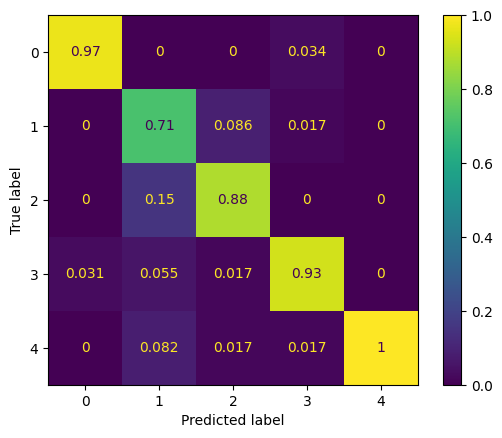

In [85]:
#Предсказываем
y_prediction = new_model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis = 1)
y_test=np.argmax(Y_test, axis=1)
#Создаем матрицу ошибок и выводим ее значения
ConfusionMatrixDisplay.from_predictions(y_test, y_prediction , normalize='pred')
report = classification_report(y_test, y_prediction)

In [86]:
model_accuracy = accuracy_score(y_test, y_prediction)
model_accuracy

0.8866666666666667

In [87]:
report = classification_report(y_test, y_prediction)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        64
           1       0.71      0.90      0.79        58
           2       0.88      0.82      0.85        62
           3       0.93      0.89      0.91        62
           4       1.00      0.85      0.92        54

    accuracy                           0.89       300
   macro avg       0.90      0.89      0.89       300
weighted avg       0.90      0.89      0.89       300

